# Emulate a Lorenz model
The objective of this notebook is to provide a tutorial that emulates a Lorenz 63 model from data only.

The general objective of this work is to present a methodology that consider a time-series ${\bf v}_0,\cdots,{\bf v}_K$ and infer a data-driven model $G({\bf v}_k)$ such as
$$
{\bf v}_{k+1} \approx G({\bf v}_k,)
$$


## Importation and initializations
This section imports and define few utilities functions. You can execute the cells below and then goes directly to the part 1-data definition.

In [1]:
## Before we start let's import few packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers


In [2]:
## We initialize the random generators so the notebook is fully reproducible

np.random.seed(2021)
tf.random.set_seed(2022)

In [3]:
## Define few utilities functions

def simulate(forward, K, v0, N=0, burnin=500):
    """
    simulate an ensemble of forward models over K time steps.
    :forward: forward model
    :K: number of time steps to generate
    :N: enseømble size (if N=0, no ensemble)
    :v0: initial state (shape: (3,N)), if N=0. (shape: (3))
    :burnin: number of initial time step to discard (spinup period)
    """
    V = np.zeros((K+burnin,N,3)) if N>0 else np.zeros((K+burnin,3)) 
    V[0,...] = v0
    for i in range(1,K+burnin):
        V[i] =forward(V[i-1])
    return V[burnin:]

def phase_plot(V,cmap='inferno', fig=None, ax=None, alpha=1, clip=True):
    """
    Plot the trajectory V in dense plot in the phase space
    """
    nbins=100
    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
    ax[1,0].hist2d(V[:,0],V[:,1], bins=(nbins,nbins),  norm=mpl.colors.LogNorm(clip=clip),cmap=cmap, alpha=alpha);
    ax[0,0].hist2d(V[:,0],V[:,2], bins=(nbins,nbins), norm=mpl.colors.LogNorm(clip=clip), cmap=cmap, alpha=alpha);
    ax[0,1].hist2d(V[:,1],V[:,2], bins=(nbins,nbins), norm=mpl.colors.LogNorm(clip=clip), cmap=cmap, alpha=alpha);
    ax[0,0].plot(V[:,0],V[:,2],color='gray',alpha=0.3)
    ax[0,1].plot(V[:,1],V[:,2],color='gray',alpha=0.3)
    ax[1,0].plot(V[:,0],V[:,1],color='gray',alpha=0.3)
    ax[1,1].axis('off');
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('y')
    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('z')
    ax[0,1].set_xlabel('y')
    ax[0,1].set_ylabel('z')


   
    return fig, ax 

def plot_3rows(x,y,ax,**kwfigs):
    for i in range(len(ax)):
        ax[i].plot(x,y[:,i],**kwfigs)
        
def rmse (xref, xest, axis=(1,),norm=True):
    """Compute the root mean square. If norm is true (default), the error is normalize by 2 standard deviation."""
    rmse_ret = np.sqrt(np.mean(np.square(xref-xest),axis=axis))
    if norm:
        rmse_ret /= 2*np.std(xref,axis=axis)
    return rmse_ret

## 1. Data definition
The Lorenz 63 model is defined on a 3-dimensional state $\mathbf{v}(t)=\{x(t),y(t),z(t)\}$ by the following equations:
\begin{align}
\frac{\mathrm{d}x}{\mathrm{d}t} &= \sigma (y - x), \\
\frac{\mathrm{d}y}{\mathrm{d}t} &= x (\rho - z) - y, \\
\frac{\mathrm{d}z}{\mathrm{d}t} &= x y - \beta z.
\end{align}
In our case we take the defaults values $\sigma = 10$, $\rho=28$, $\beta=8/3$

Let's define the Lorenz equations:

In [4]:
# Parameters of the Lorenz model
sig = 10.
rho = 28.
beta = 8./3

def Lorenz_model(v, sig=sig, rho=rho, beta=beta):
    """
    Compute the Lorenz 63 tendencies
    """
    x, y, z = v[...,0], v[...,1], v[...,2]
    
    dxdt = sig*(y-x)
    dydt = rho*x - y - x*z
    dzdt = x*y - beta*z
    
    return np.stack((dxdt, dydt, dzdt),axis=-1)

We integrate the ODEs (Ordinary Differential Equations) using a runge kutta scheme on discrete time steps $t_k$ such as $t_{k+1}-t_k = \delta t = 0.01$ (by default). We denote $\mathcal{M}$ the inegretion operator (sometimes called the *resolvent*) over a time step $\delta t$, such as:
$$
{\bf v_{k+1}} = \mathcal{M}({\bf v_{k}})
$$

In [5]:
def RK4 (model, v, dt):
    """
    Integrate the model over dt using initial conditions v
    """
    k1 = model(v)
    k2 = model(v + dt*k1/2.)
    k3 = model(v + dt*k2/2.)
    k4 = model(v + dt*k3)
    return v + (1./6.)*dt*(k1 + 2*k2 + 2*k3 + k4)

Now we are almost ready to generate all the data. We are defining all the necessary parameters (some of which will be explained later on). You can play with thoses parameters to see the effect of some of them (e.g. the size of the training set, or the noise of the training set).

In [6]:
dt = 0.01 # integration time step
K = 50000 # size of the reference simulation
Ktrain=10000 # Number of samples in the training set
Kval = 5000 # Number of samples in the validation set
Ktest = 2000 # Number of samples in the test set (used to assess the forecast skill)
Ntest = 500 # Size of the test set ensemble
v0ref = np.array([1.509, -1.531, 25.46]) # Reference point to initialize simulations
stdo = 0 #Relative noise on the data

Now, let's simulate the data for the reference set and the test set

In [7]:
# Define the resolvent
forward = lambda v: RK4(Lorenz_model, v,dt)

#Reference dataset generation
v0 = v0ref + 0.1*np.random.randn(3)
v = simulate(forward, K, v0)


# Define the noise field
sigma = np.std(v,axis=0)
noise = stdo*sigma*np.random.randn(K,3)

# Extract the training and validation set (add noise on the training)
Xtrain = v[0:Ktrain] +  noise[0:Ktrain]
ytrain = v[1:Ktrain+1] + noise[1:Ktrain+1]

Xval = v[Ktrain:Ktrain+Kval]
yval = v[Ktrain+1:Ktrain+Kval+1]

# Test set (ensemble) generation
v0test = v0ref[np.newaxis,:] + 0.1*np.random.randn(Ntest,3)
vtest = simulate(forward, Ktest, v0test, N=Ntest)
ttest = dt*np.arange(Ktest) #Time scale of the test datset

# Print the size
print(f'Size of the reference set: {v.shape}\nSize of the test set: {vtest.shape}')


Size of the reference set: (50000, 3)
Size of the test set: (2000, 500, 3)


**We recomend to always have a look at the dataset and its main characteristic, using simple visualization, before running any processing.**

We now plot the simulations of few time steps of one member of the test simulation

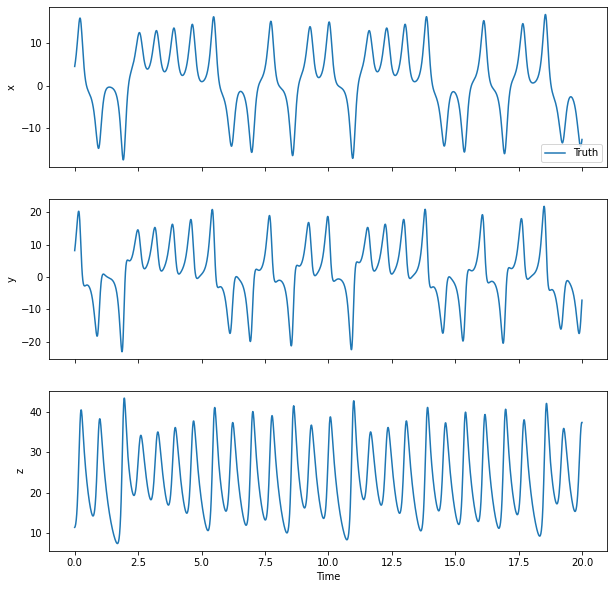

In [8]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10),sharex=True)
plot_3rows(ttest,vtest[:,1],ax,color='C0',label='Truth')
ax[0].legend();
ax[2].set_xlabel('Time');
ax[0].set_ylabel('x');
ax[1].set_ylabel('y');
ax[2].set_ylabel('z');

Ater a transient period (model spinup), discarded in the simulations, the vector ${\bf v}$ takes value in a subspace of the $\mathbb{R}^3$, called the **model attractor**. We can represents in the density of  values of the attractor (plot in the phase space). 

N.B. we use the python ```hist3``` that "bin" the data to represent the density. Due to binning effect, the density in the edge of the attractor seems like discontinous points whereas the trajectory are continous

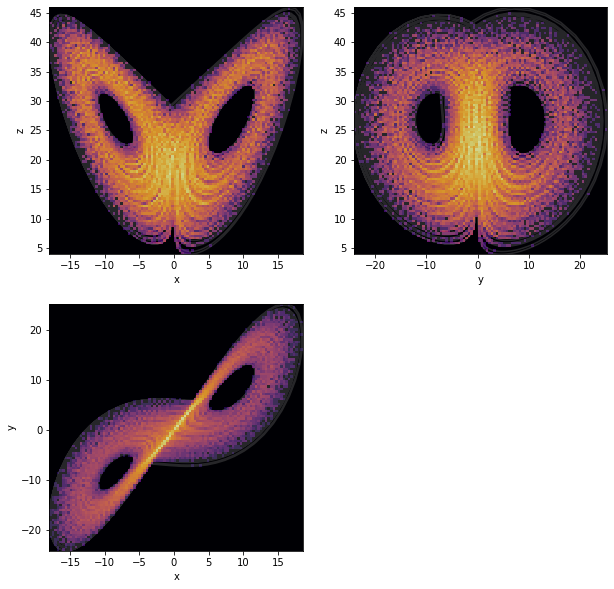

In [9]:
fig, ax = phase_plot(v)


If we do the same phase plot but limited to training set, it can be seen that the denser parts attractor are covered by the training set, but the edges (less frequent) are undersampled.

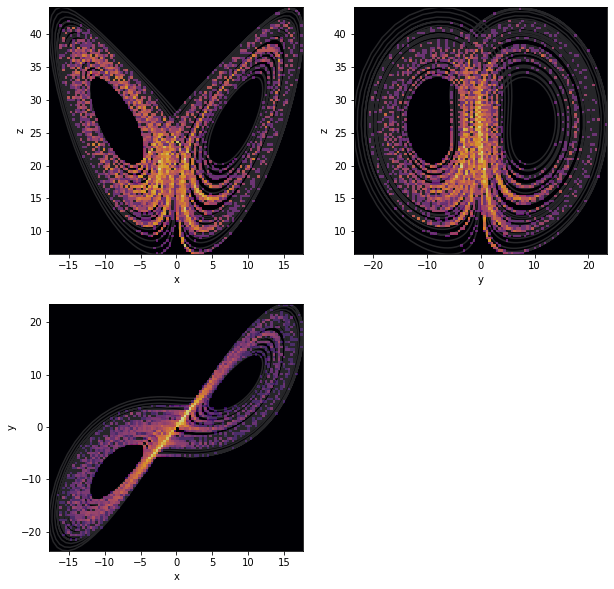

In [10]:
fig, ax = phase_plot(Xtrain)


<span style="color:red">**OBJECTIVE OF THIS NOTEBOOK**</span> 

Given the dataset ${\bf v}_0,\cdots,{\bf v}_K$ in the training set, we want to determine a data driven model $G({\bf v}_k,\theta)$, such as:
$$
{\bf v}_{k+1} = G({\bf v}_k,\boldsymbol{\theta}) + \epsilon_k,
$$
where $\epsilon_k$ is the error of the data-driven model, $\boldsymbol{\theta}$ is the set of parameter of the data-driven model to be adjusted the the error is minimum. To achieve this objective, the following loss (also call cost function) is minimized:
$$
L(\boldsymbol{\theta}) = \sum_{k=1}^K \left[ {\bf v}_{k+1} - G({\bf v}_k,\boldsymbol{\theta}) \right]^2
$$.

If the data-driven model is perfect $L(\boldsymbol{\theta})=0$ and $G({\bf v}_k,\boldsymbol{\theta}) = \mathcal{M}({\bf v_{k}})$

<span style="color:red">**EVALUATION OF THE DATA-DRIVEN MODEL**</span> 

The model $G({\bf v}_k,\boldsymbol{\theta})$ is evaluated for 2 distincts properties:
1. **The forecast skill** Given the same initial condition ${\bf v}_0$, how far in time the prediction of the model is accurate, i.e. $G^h({\bf v}_0,\boldsymbol{\theta}) - \mathcal{M}^h({\bf v_{0}})$ is small? This property is evaluated by commputing the root-mean square error in time over an ensemble of indepednant initial conditions (the size of the ensemble is given by the variable ```Ntest```
2. **The climate of the model** If we integrate the data-driven model over a long time, how good the attractor is reproduced? This property is assessed by comparing qualitatively the atttractor of the true model and the data-driven model.

*N.B. In this notebook, we only present a few assessments of the performances. There are of course a large variety of scores to asssess the quality of the data-driven model (e.g. Lyapunov exponents, energy spectrum, ...). The following papers give example of complete assessment that can be done on a data-driven model.See for example:*
- Pathak, Jaideep, et al. "Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data." Chaos: An Interdisciplinary Journal of Nonlinear Science 27.12 (2017): 121102. https://aip.scitation.org/doi/full/10.1063/1.5010300?casa_token=zAZf0spCswoAAAAA:KsWSuFIGVCVvKSvV5U225tD_W1sn0bRF4G-0weOFXNwx0-v80d-NhcMMRivIj6VFdZ704S7ePiBh

- Brajard, Julien, et al. "Combining data assimilation and machine learning to emulate a dynamical model from sparse and noisy observations: a case study with the Lorenz 96 model." Journal of Computational Science 44 (2020): 101171.
https://www.sciencedirect.com/science/article/pii/S1877750320304725?casa_token=1TZhvVKQx8AAAAAA:lKVvhP7Wg7cILKQNSXlpdXXXKxrt_RVlUn1VJLRUlSCSAm1f4bOuMId2EMRVHLhW-qkb8-DS3w4

## 2. A simple baseline
Before designing any complex (or even not so complex) machine learning approach, it is recommended to test a **simple and naive baseline**. Here we try a simple **linear model** as a very simple data-driven model.


First, The linear model is fitted on the training dataset:

In [11]:
reg = LinearRegression().fit(Xtrain, ytrain)


Second, the predictions for the validation dataset are computed.

In [12]:
ylin = reg.predict(Xval)

Then, the true values are compared with the linear prediction

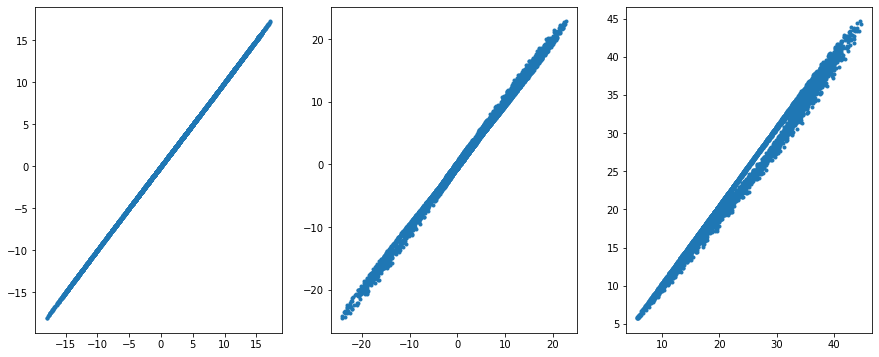

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ylin[:,0],'.')
ax[1].plot(yval[:,1],ylin[:,1],'.')
ax[2].plot(yval[:,2],ylin[:,2],'.')

It seems that the linear model does a pretty good job here. But the scatter plots show only the error after an integration of a small time increment $\Delta t$. We need to assess the skill of the model used on a longer time (for the forecast and the reproduction of the climate)

So we compute the forecast of the linear model with the same ensemble of initial condition as the test dataset:

In [14]:
vtestlin = simulate(reg.predict, Ktest, vtest[0], N=Ntest,burnin=0)


Text(0, 0.5, 'z')

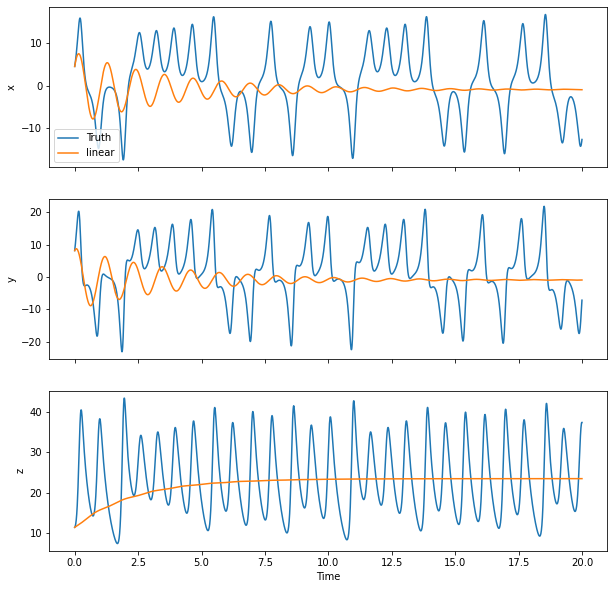

In [15]:
fig, ax = plt.subplots(nrows=3,figsize=(10,10),sharex=True)
plot_3rows(ttest,vtest[:,1],ax,color='C0',label='Truth')
plot_3rows(ttest,vtestlin[:,1],ax,color='C1',label='linear')
ax[0].legend()
ax[2].set_xlabel('Time')
ax[0].set_ylabel('x')
ax[1].set_ylabel('y')
ax[2].set_ylabel('z')

On the previous example, it can be seen that the linear model is only a amortized oscillator, that have a very limited forecast skill. Let's have a look at the forecast skill averaged over the 500 examples of the dataset

Text(0.5, 0, 'Time')

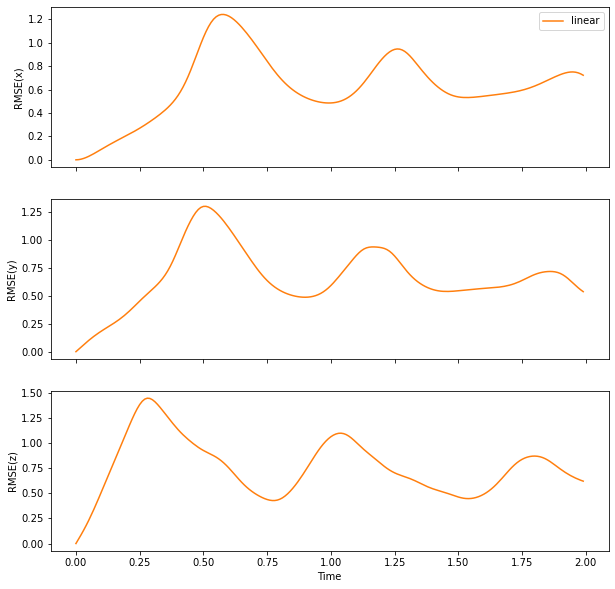

In [16]:
rmse_lin = rmse(vtest, vtestlin)
fig, ax = plt.subplots(nrows=3,figsize=(10,10),sharex=True)
plot_3rows(ttest[:200],rmse_lin[:200],ax,color='C1',label='linear')
ax[0].legend()
ax[0].set_ylabel('RMSE(x)')
ax[1].set_ylabel('RMSE(y)')
ax[2].set_ylabel('RMSE(z)')
ax[2].set_xlabel('Time')


There is not much we can conclude from the previous figure. We see that the error reaches 60% after .25 times for $x$ and $y$ and afet 0.15 times for $z$. It gives a baseline our data-driven model needs outperform.

Now we can have a look at the climate reconstruction by plotting the attractor of the linear data-driven model:

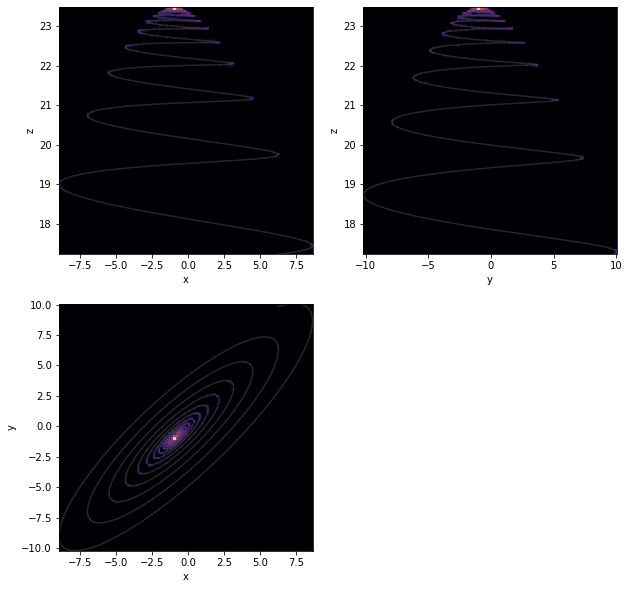

In [17]:
vtestlinlong = simulate(reg.predict, K, vtest[0,:1], burnin=0, N=1).squeeze()
fig, ax = phase_plot(vtestlinlong)


The model is converging to a single fixed point, which is very different from the expected attractor.

## 2. The neural network emulator
First, let's define the list of parameters for the neural network. Don't hesitate to play with the parameters to see the effect of each of them.

In [18]:
norm_input = True #Standardization of the input vector
nhid1 = 50 # Number of neurons in the first hidden layer
nhid2 = 40 # Number of neurons in the second hiddent layer
epochs = 200 # Number of epochs during optimization
optimizer = 'Adam'# Optimizer used for the trainin

Compute the normalization of the input:

In [19]:
if norm_input:
    mean_ = np.mean(Xtrain,axis=0,keepdims=True)
    std_= np.std(Xtrain,axis=0, keepdims=True)
    norm = lambda x: (x-mean_)/std_
    denorm = lambda x: x*std_ + mean_
else:
    norm = lambda x: x
    denorm = lambda x: x

Define the neural network model

In [20]:
nn_model = keras.Sequential(
    [
        layers.Dense(nhid1, activation="tanh", name="layer1", input_shape=(3,)),
        layers.Dense(nhid2, activation="tanh", name="layer2"),
        layers.Dense(3, name="output", activation="linear"),
    ])


nn_model.compile(optimizer=optimizer, loss='mse')

Have a look at the model


In [21]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 50)                200       
_________________________________________________________________
layer2 (Dense)               (None, 40)                2040      
_________________________________________________________________
output (Dense)               (None, 3)                 123       
Total params: 2,363
Trainable params: 2,363
Non-trainable params: 0
_________________________________________________________________


Now we need to compile the model (it is a particularity of tensorflow) and specify the loss function and the optimizer.


It is now possible de train the model (optimize the parameters)

In [22]:
history = nn_model.fit(norm(Xtrain),ytrain, validation_data=(norm(Xval),yval),epochs=epochs)

Epoch 1/200
313/313 [==============================] - 1s 2ms/step - loss: 188.1899 - val_loss: 50.4211
Epoch 2/200
313/313 [==============================] - 0s 597us/step - loss: 38.5529 - val_loss: 22.1361
Epoch 3/200
313/313 [==============================] - 0s 598us/step - loss: 18.9052 - val_loss: 10.6566
Epoch 4/200
313/313 [==============================] - 0s 589us/step - loss: 9.0759 - val_loss: 5.3598
Epoch 5/200
313/313 [==============================] - 0s 603us/step - loss: 4.4148 - val_loss: 2.7985
Epoch 6/200
313/313 [==============================] - 0s 586us/step - loss: 2.4553 - val_loss: 1.6121
Epoch 7/200
313/313 [==============================] - 0s 594us/step - loss: 1.3738 - val_loss: 0.9868
Epoch 8/200
313/313 [==============================] - 0s 603us/step - loss: 0.8674 - val_loss: 0.6472
Epoch 9/200
313/313 [==============================] - 0s 598us/step - loss: 0.5033 - val_loss: 0.4430
Epoch 10/200
313/313 [==============================] - 0s 587us/ste

313/313 [==============================] - 0s 588us/step - loss: 4.9095e-04 - val_loss: 7.5022e-04
Epoch 79/200
313/313 [==============================] - 0s 572us/step - loss: 5.0841e-04 - val_loss: 0.0010
Epoch 80/200
313/313 [==============================] - 0s 602us/step - loss: 9.9037e-04 - val_loss: 6.3881e-04
Epoch 81/200
313/313 [==============================] - 0s 705us/step - loss: 6.3089e-04 - val_loss: 8.3847e-04
Epoch 82/200
313/313 [==============================] - 0s 594us/step - loss: 7.3420e-04 - val_loss: 7.0026e-04
Epoch 83/200
313/313 [==============================] - 0s 584us/step - loss: 5.5351e-04 - val_loss: 4.6315e-04
Epoch 84/200
313/313 [==============================] - 0s 573us/step - loss: 6.0353e-04 - val_loss: 6.7278e-04
Epoch 85/200
313/313 [==============================] - 0s 581us/step - loss: 6.2143e-04 - val_loss: 7.4478e-04
Epoch 86/200
313/313 [==============================] - 0s 596us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 87/200
313/

313/313 [==============================] - 0s 590us/step - loss: 7.6050e-04 - val_loss: 2.5141e-04
Epoch 152/200
313/313 [==============================] - 0s 576us/step - loss: 2.7376e-04 - val_loss: 2.6536e-04
Epoch 153/200
313/313 [==============================] - 0s 572us/step - loss: 3.1270e-04 - val_loss: 5.5038e-04
Epoch 154/200
313/313 [==============================] - 0s 577us/step - loss: 4.3085e-04 - val_loss: 8.0863e-04
Epoch 155/200
313/313 [==============================] - 0s 577us/step - loss: 4.3324e-04 - val_loss: 0.0019
Epoch 156/200
313/313 [==============================] - 0s 574us/step - loss: 3.9582e-04 - val_loss: 6.1203e-04
Epoch 157/200
313/313 [==============================] - 0s 574us/step - loss: 4.4685e-04 - val_loss: 3.9818e-04
Epoch 158/200
313/313 [==============================] - 0s 591us/step - loss: 7.6924e-04 - val_loss: 2.2613e-04
Epoch 159/200
313/313 [==============================] - 0s 577us/step - loss: 2.8752e-04 - val_loss: 0.0010
Epoch

Before assessing the performance of the NN model, we have look at the loss decreasing over the epochs for the training dataset and the validation dataset. The training loss is expected to decrease during the training (if not, it denotes a very serious problem on the data or on the model). It is also important to verify that the validation loss is also decrasing, otherwise it can reveal that the NN model is **overfitting** on the data.

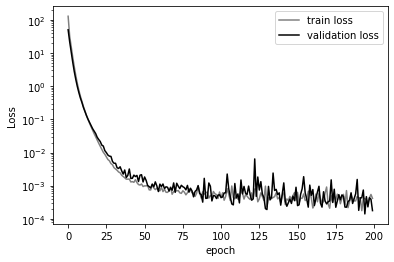

In [23]:
fig, ax = plt.subplots()
ax.semilogy(history.history['loss'],color='gray',label='train loss')
ax.semilogy(history.history['val_loss'],color='black',label='validation loss')
ax.legend()
ax.set_xlabel('epoch');
ax.set_ylabel('Loss');

Prediction of the model on the validation set:

In [24]:
ynn = nn_model.predict(norm(Xval))

Look at the scatter plots:

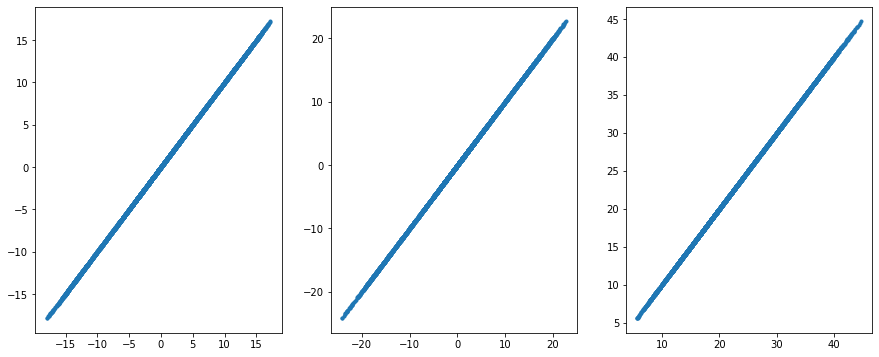

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
ax[0].plot(yval[:,0],ynn[:,0],'.')
ax[1].plot(yval[:,1],ynn[:,1],'.')
ax[2].plot(yval[:,2],ynn[:,2],'.')

The scatter plots looks almost perfect. But remember that they were also looking good for the linear model baseline. This shows only the skill of the NN model adter a short $\Delta t$ time step. Now we need to assess the NN model on longer time.

Define the resolvant of the NN nodel:

In [26]:
forward_nn = lambda v: nn_model(norm(v), training=False)[...,:3]


Integrate the NN model over the test dataset and plot one trajectory

In [27]:
vtestnn = simulate(forward_nn, Ktest, vtest[0], N=Ntest,burnin=0)


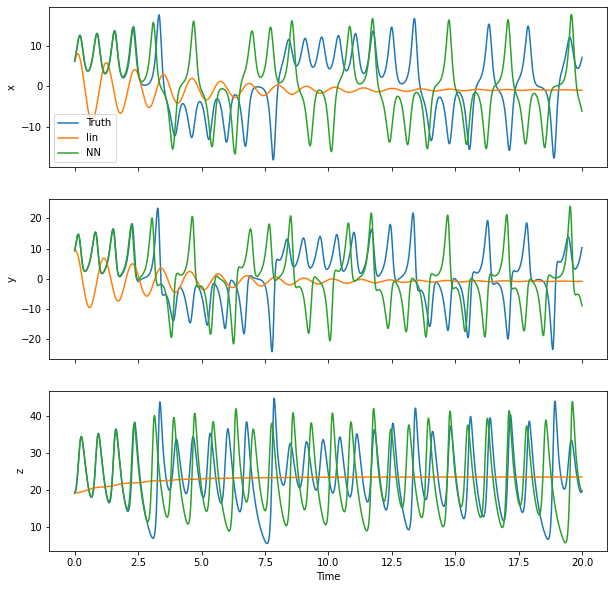

In [28]:
NN = 2100
fig, ax = plt.subplots(nrows=3,figsize=(10,10),sharex=True)
plot_3rows(ttest[:NN],vtest[:NN,2],ax,color='C0',label='Truth')
plot_3rows(ttest[:NN],vtestlin[:NN,2],ax,color='C1',label='lin')

plot_3rows(ttest[:NN],vtestnn[:NN,2],ax,color='C2',label='NN')

ax[0].legend()
ax[2].set_xlabel('Time')
ax[0].set_ylabel('x');
ax[1].set_ylabel('y');
ax[2].set_ylabel('z');

It is clear that the NN model "follows" the true simulation for a longer time, and also the simulation is very similar to the true simulation. Note here that, due to the chaotic nature of the dynamic, any model model is expected to diverge with respect to the truth.

Now we can assess the forecast skill and compare it to the forecast skill of our linear model baseline.

Text(0, 0.5, 'RMSE(z)')

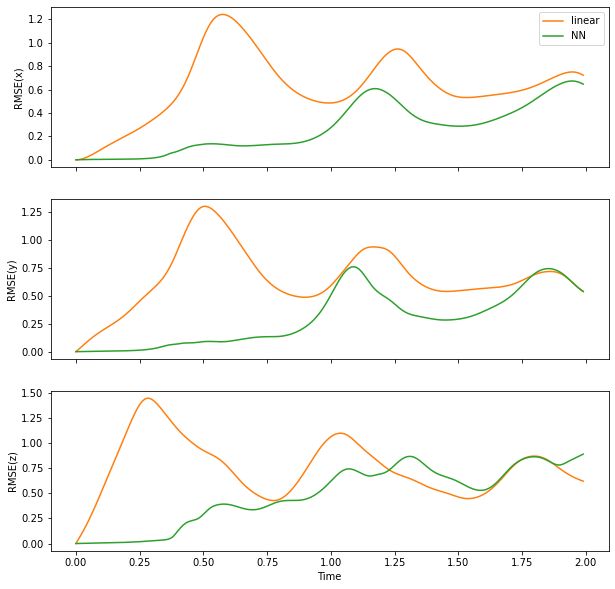

In [29]:
rmse_nn = rmse(vtest, vtestnn)
fig, ax = plt.subplots(nrows=3,figsize=(10,10), sharex=True)
plot_3rows(ttest[:200],rmse_lin[:200],ax,color='C1',label='linear')
plot_3rows(ttest[:200],rmse_nn[:200],ax, color='C2',label='NN')

ax[0].legend()
ax[2].set_xlabel('Time')
ax[0].set_ylabel('RMSE(x)')
ax[1].set_ylabel('RMSE(y)')
ax[2].set_ylabel('RMSE(z)')

It is very clear that the NN model outperforms the linear model. The error stays under 60% for more than 2 time units instead of 0.25 for the linear model, so the horizon of prediction has been roughly improve by a factor of 8.

Finally, let's assess the long-term properties of the NN model.We make a long simulation of the NN model and visualize the attractor

In [30]:
vtestnnlong = simulate(forward_nn, K, vtest[0,:1], burnin=0, N=1).squeeze()


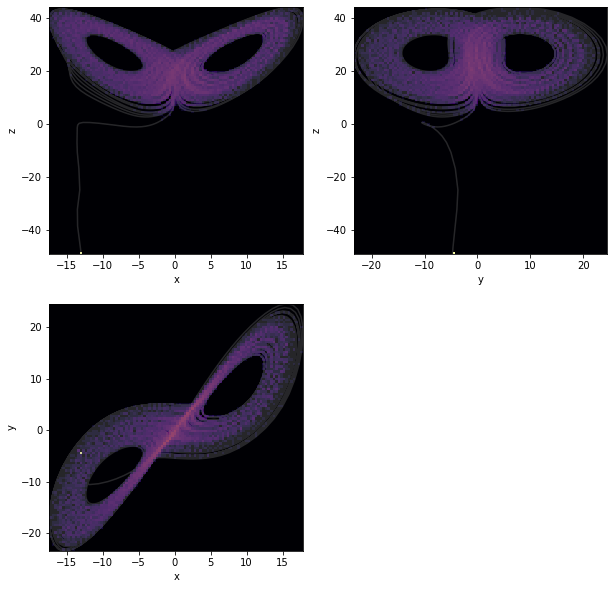

In [31]:
fig, ax = phase_plot(vtestnnlong)

The attractor of the NN model is very close to the attractor of the true model.
If we plot the NN model atttractor together with the attractor of the true model, it can seen that the NN model is not reproducing well the extremes cases. The main reason is that the extremes are not well represented in the training dataset. The NN model has only "seen" the training set, and it shows that it is challenging to extrapolate to extremes cases.